<b>
<p>
<center>
<font size="6">
DATS 6202 Final: Predicting Poverty Rates with Demographic Data
</font>
</center>
</p>

<p>
<center>
<font size="4">
Author: Jehan Bugli
</font>
</center>
</p>

# Introduction

## Problem & Motivation

[Nearly 10% of the United States](https://www.whitehouse.gov/cea/written-materials/2024/09/10/the-2023-income-poverty-and-health-insurance-reports-strong-household-income-gains-lower-official-poverty-uninsured-rate-near-record-low/#:~:text=The%20official%20poverty%20rate%2C%20which,Figure%202%20shows%20these%20trends) lives in poverty, presenting a serious issue at odds with the nation's status as a global economic powerhouse.

Understanding root causes of poverty is a natural first step to crafting policy solutions to better address this issue; some of these causes may be well within reach for regulatory agencies, while knowledge of immutable factors can still help guide assistance more intelligently.

Factors influencing poverty are manifold, and I cannot model them all within the scope of this project. However, I think it presents a unique opportunity to highlight a subset of potential inputs and evaluate their effects. In particular, I'm interested in how demographics and local circumstances influence poverty rates.







## Dataset and Data Collection Methodology

My examination uses the [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs/about.html), an annual survey conducted by the Census Bureau covering a wide range of topics (including poverty). This source stood out for a few reasons:
- ACS data is collected on a far more granular level than any other source to my knowledge
- The ACS tracks data points that overlapped exceptionally well with potential poverty factors I was interested in examining
- Data was readily available via public API, leaving no concerns about accessibility or integrity beyond my own ability to utilize those resources



Armed with a clear direction, my next step was to actually gather the data! The Census API offers [multiple options](https://api.census.gov/data/2022/acs.html) with respect to the ACS; the 'detailed tables' endpoint, containing the information of interest, includes both 1-year and 5-year breakouts. These represent a tradeoff between recency and specificity; I ultimately chose to use the 5-year breakout so that I could drill down to the ['block' level, which is the smallest geographical unit that the Census provides](https://www.census.gov/newsroom/blogs/random-samplings/2011/07/what-are-census-blocks.html).

I initially entered this investigation planning to use ZIP codes; however, the [lack of defined boundaries](https://proximityone.com/tracts_zips.htm#:~:text=Census%20tracts%20are%20polygons%20and,points%20not%20even%20one%20line) and reduced dataset observations led me away from this approach.



To retain modularity and save time, especially while fine-tuning my models, I opted to split Census data grabs out into a separate ACS_Data_Grab.py file. This file took the following steps:
- Define all desired data points from the ACS (by code and a short string) in a dictionary
- Make an initial call to the Census API to retrieve all state codes / names, saving those in a separate dictionary
- Get all of the data for each state, splitting queries into two halves (observing an API limitation on fields per request) and subsequently consolidate entries for each census block
- Save to a .csv file

Once I had this pipeline built out, the next major milestone was figuring out which exact data points were both available and worth investigating. In certain cases, for instance, I found that certain fields weren't broken down to the block level (e.g. certain nativity fields).

Importantly, I did not want to include any variables that could be seen as reasonably direct proxies for poverty. For instance, a count of individuals receiving food stamps, SNAP, or public assistance is a product of poverty without practical predictive value from a policy-making perspective. Similarly, data points involving employment, salary, etc. are not useful model inputs for my purposes.

I settled on a few major categories:
- Total population (used for calculations, not as a model input)
- Individuals below the poverty level (my pre-transformed target variable)
- Counts of individuals in granular age brackets, split by gender (I combine these for a gender-agnostic view)
- Count of individuals with hispanic ethnicity
- Count of individuals by race
- Count of individuals by their method of transportation to work
- Count of individuals by educational attainment
- Count of individuals currently enrolled in school
- Count of available housing units
- The median year in which buildings were constructed
- Count of individuals by veteran status
- Count of individuals by their home language being English alone
- Count of individuals by travel time to work (60-89 and 90+ categories are combined for one 60+ category)


I converted most variables to reflect percentages of the total population, standardizing interpretation over different blocks with different population sizes. State codes were converted into a set of dummy variables using one-hot encoding; dimensionality concerns were fully negated by performance gains without overfitting.

## Goals & Expectations

In summary, my high-level goal is to determine the impacts of the specified personal and environmental variables on poverty rates for a given Census block group.

I aim to apply various models, searching for the maximum extent to which these inputs influence poverty rates; notably, this means that perfect predictions are not my main goal!

The factors listed here are certainly not the only real-world influences on poverty rates, but they are among the most closely tracked; my goal is to investigate the extent of their impacts rather than demonstrate that they fall above some arbitrary threshold of importance.

# Experiment

## Notebook Configuration

Initial notebook setup steps are largely lifted from case studies.

### Google drive

In [1]:
# Standard drive setups from prior case studies

from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/final/FA24_DATS6202_Final/'

# Get the absolute path of the shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p2_shallow_learning/'

# Get the absolute path of the shallow models folder
abspath_model_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/models/p2_shallow_learning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Code to make a directory for grid search results

import os

# Make directory for grid search results to use
directory = os.path.dirname(abspath_curr + '/result/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# Taken from prior case studies

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

### Matplotlib

In [4]:
# Taken from prior case studies

import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

### TensorFlow

In [5]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Random seed

In [6]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

### Import utilities

In [7]:
# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p2_shallow_learning


## Data Preprocessing

### Loading the data

After initial notebook setup, I started by loading the data.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load all of the data
df = pd.read_csv(abspath_curr + '/data/census_data.csv', header=0)

### Raw dataframe alterations

The loaded CSV contains all of the fields necessary for my analysis; however, in their raw form, they aren't suitable for modeling. I engaged in a number of initial steps to transform the data.

#### Census block population minimum

First of all, I removed any census blocks with less than 500 individuals. The vast majority of blocks fall above this threshold; I wanted to remove any extreme outlier observations from ultra-low-population blocks that could skew results. In practical terms, while I chose Census blocks due to their granular observations, I'm not concerned with such subsets.

In [9]:
# Filter dataframe rows where the total census block has less than a certain population
# At the risk of potentially making the rural/urban split less representative of the overall population, this is meant to remove any extreme outlier observations in training and testing due to the granular nature of these breakouts

# Define a population size minimum and create a boolean array to apply to the dataframe
pop_cutoff = 500
pop_filter = df['total_pop'] >= pop_cutoff

# Filter the dataframe
print(f"Removing dataframe rows with less than {pop_cutoff} people: {len(df)-(pop_filter).sum()}/{len(df)} observations")
df = df[pop_filter]

Removing dataframe rows with less than 500 people: 13154/242336 observations


#### Imputing median year in which structures were built

In the original dataset, some of the Census API values for the median year in which structures are built are provided as '-666666666'; the meaning of this is unclear in my research, but rather than tossing such observations, I opted to impute the median year using the average of the given state and county.

I grouped the dataframe by state and county, calculating the average of this field (for rows that don't have the negative year input); then, I substituted this average into the dataset.

I think there could be minor "leakage" concerns, but in testing I didn't notice any appreciable benefits to conducting this post-split or dropping such rows.

In [10]:
# Some of the Census API values for 'med_year_built' are provided as '-666666666' (meaning is unclear in my research); these are imputed using the average of the given state and county

# Group year built by state and county values, calculating the average
grouped_year_means = df.groupby(['state', 'county'])['med_year_built'].transform(lambda x: x[x > 0].mean())

# Use the average value of a given state + county for all blocks where the median year built is less than 0
df['med_year_built_imputed'] = df['med_year_built'].where(df['med_year_built'] > 0, grouped_year_means)

# Filter out NaN values in 'med_year_built_imputed' (indicating that the whole block is missing the metric) and drop the original column
df = df.dropna(subset=['med_year_built_imputed']).drop(columns=['med_year_built'])

#### (Unused) One-hot encoding for states as a geographic proxy

After this, I attempted a large transformation by generating one-hot-encoded fields for each state. By default, the models being trained are not geographic in nature, and this was an attempt to compensate for that. State of residence intuitively seems like an important factor given [significant outcome disparities](https://www.americanprogress.org/data-view/poverty-data/poverty-data-map-tool/).

Ultimately, while there were some benefits under certain targets, the classification method I ultimately used saw essentially no benefits from these added fields, and I opted to remove them.

I also attempted filtering the dataset to narrow down to a specific region (e.g. DC, Maryland, and Virginia); surprisingly, I saw no improvements in predictive validity, so I ultimately abandoned that approach.

In [11]:
# Note that this uses state codes as provided in the data, not state abbreviations/names: https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html

# [DEPRECATED] Use one-hot encoding for states as a rough approximation for geography given that this model otherwise does not incorporate location
#df = pd.get_dummies(df, columns=['state'])

df.drop(columns=['state'], inplace=True)

#### Identifiers

None of the other identifiers were used in my analysis, so I dropped them from the dataframe.

In [12]:
# Drop known identifiers
df.drop(columns=['NAME', 'county', 'tract', 'block group'], inplace=True)

#### Converting housing units to individuals per housing unit

By default, a raw number of housing units is provided; I convert this to individuals per unit (dividing the total block population by the number of housing units) since that seems like a more useful metric of housing availability.

In [13]:
# By default, a raw number of housing units is provided; I convert this to individuals per unit since that seems like a more useful metric of housing availability

# Calculate new metric
df['indivs_per_housing_unit'] = df['total_pop'] / df['housing_units']

# Drop original housing units field
df.drop(columns='housing_units', inplace=True)

#### Consolidating commute times above an hour

The data includes both 60-89 minute and 90+ minute travel times; these are combined into a single 60+ minute field as a percentage of all individuals.

In [14]:
# Generate the combined field
df['travel_time_60+'] = (df['travel_time_60_89'] + df['travel_time_90+'])/df['travel_time_total']

# Drop the now-unused input fields
df.drop(columns=['travel_time_60_89', 'travel_time_90+', 'travel_time_total'], inplace=True)

#### Consolidating gender-based age brackets

By default, the dataset separates male-female ages in each of the many detailed brackets. While separated categories aided certain models, consolidated gender-agnostic age brackets performed better on average across different model types.

I consolidated these into a single gender-agnostic column for each age bracket using a custom formula.

In [15]:
def combine_ages(col_m):

  # Get the implied name of the associated female age column
  col_f = col_m.replace('male', 'female')

  # Construct a new name for the combined metric
  col_new = col_m.replace('male', 'age')

  # Create a new column adding both male and female individuals within a given age group
  df[col_new] = df[col_m] + df[col_f]

  # Drop the original columns
  df.drop(columns=[col_m, col_f], inplace=True)

In [16]:
# Import regex library to search for column name stype
import re

# Iterate through columns, searching for male age columns (with the given pattern) and combining male/female age groups

for col in df.columns:

  match = re.match(r'^male_\d+.*$', col)

  if match:
    combine_ages(col)
    print(f"{col} & {col.replace('male', 'female')} -> {col.replace('male', 'age')}")

male_0_4 & female_0_4 -> age_0_4
male_5_9 & female_5_9 -> age_5_9
male_10_14 & female_10_14 -> age_10_14
male_15_17 & female_15_17 -> age_15_17
male_18_19 & female_18_19 -> age_18_19
male_20 & female_20 -> age_20
male_21 & female_21 -> age_21
male_22_24 & female_22_24 -> age_22_24
male_25_29 & female_25_29 -> age_25_29
male_30_34 & female_30_34 -> age_30_34
male_35_39 & female_35_39 -> age_35_39
male_40_44 & female_40_44 -> age_40_44
male_45_49 & female_45_49 -> age_45_49
male_50_54 & female_50_54 -> age_50_54
male_55_59 & female_55_59 -> age_55_59
male_60_61 & female_60_61 -> age_60_61
male_62_64 & female_62_64 -> age_62_64
male_65_66 & female_65_66 -> age_65_66
male_67_69 & female_67_69 -> age_67_69
male_70_74 & female_70_74 -> age_70_74
male_75_79 & female_75_79 -> age_75_79
male_80_84 & female_80_84 -> age_80_84
male_85+ & female_85+ -> age_85+


#### Percentage conversions

After this, my next major step was to convert most of these fields into percentages based on block population. While most census blocks have roughly similar sizes, proportional metrics avoid any potential model interpretation issues that might come from such variance.

I crafed a function for such conversions along with a batch conversion function for fairly predictable processing steps (including most of my fields); then, I applied them to my dataset.

##### Pre-adjustment dataframe:

In [17]:
df

,total_pop,below_poverty_level,age_total,ethnicity_total,ethnicity_hispanic,race_total,race_white,race_black,race_native,race_asian,...,age_50_54,age_55_59,age_60_61,age_62_64,age_65_66,age_67_69,age_70_74,age_75_79,age_80_84,age_85+
0,558,38,558,558,51,558,475,12,0,0,...,61,13,6,70,39,17,28,28,31,0
1,1307,20,1307,1307,30,1307,1025,196,0,45,...,71,190,43,0,8,30,51,20,56,55
2,548,4,548,548,2,548,176,327,0,0,...,24,41,32,48,27,46,26,13,6,0
3,1313,16,1313,1313,0,1313,500,715,0,0,...,108,119,40,37,18,80,22,22,0,33
4,2835,14,2835,2835,44,2835,2022,619,0,11,...,157,356,116,10,2,25,154,31,40,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242331,1616,79,1616,1616,1577,1616,1218,77,0,0,...,104,108,44,78,0,32,72,113,0,20
242332,1787,108,1787,1787,1787,1787,1068,51,0,0,...,121,81,50,93,55,75,104,85,31,0
242333,1291,49,1291,1291,1291,1291,1071,34,0,0,...,45,57,12,53,34,71,28,77,64,3
242334,1294,244,1294,1294,1272,1294,858,14,0,0,...,105,110,54,82,43,81,125,162,160,0


In [18]:
# Define a function that converts a given column into a percentage based on a certain total (generally I'll use the grouping-specific totals if available because they don't always match the main total)

def convert_pct(col, col_total='total_pop', new_name = None):

  # Rename the column with the provided new name (or append '_pct' by default)
  if new_name is None:
      new_name = col + '_pct'

  df[col] = df[col] / df[col_total]
  df.rename(columns={col: new_name}, inplace=True)

# Define a function that iterates through columns to execute percentage conversions on a set of columns with a common prefix / predictable syntax

def convert_pct_batch(col_string):
  for col in df.columns:
    if col.startswith(col_string) and col != col_string + '_total':
      convert_pct(col, col_string + '_total')

  df.drop(columns=col_string + '_total', inplace=True)


In [19]:
# Execute batch conversions

for string in ['age', 'race', 'ethnicity', 'edu', 'trans', 'vet', 'home_lang']:

  convert_pct_batch(string)

In [20]:
# Convert poverty level and school enrollment separately (note that this replaces the existing column with a '_pct' suffix to denote the alteration)
convert_pct('below_poverty_level')
convert_pct('school_enrolled')

##### Post-adjustment dataframe:

In [21]:
df

,total_pop,below_poverty_level_pct,ethnicity_hispanic_pct,race_white_pct,race_black_pct,race_native_pct,race_asian_pct,race_other_pct,trans_car_alone_pct,trans_carpool_pct,...,age_50_54_pct,age_55_59_pct,age_60_61_pct,age_62_64_pct,age_65_66_pct,age_67_69_pct,age_70_74_pct,age_75_79_pct,age_80_84_pct,age_85+_pct
0,558,0.068100,0.091398,0.851254,0.021505,0.0,0.00000,0.016129,0.799197,0.200803,...,0.109319,0.023297,0.010753,0.125448,0.069892,0.030466,0.050179,0.050179,0.055556,0.000000
1,1307,0.015302,0.022953,0.784239,0.149962,0.0,0.03443,0.000000,0.848352,0.134066,...,0.054323,0.145371,0.032900,0.000000,0.006121,0.022953,0.039021,0.015302,0.042846,0.042081
2,548,0.007299,0.003650,0.321168,0.596715,0.0,0.00000,0.000000,0.739130,0.019763,...,0.043796,0.074818,0.058394,0.087591,0.049270,0.083942,0.047445,0.023723,0.010949,0.000000
3,1313,0.012186,0.000000,0.380807,0.544554,0.0,0.00000,0.006093,0.998435,0.001565,...,0.082254,0.090632,0.030465,0.028180,0.013709,0.060929,0.016756,0.016756,0.000000,0.025133
4,2835,0.004938,0.015520,0.713228,0.218342,0.0,0.00388,0.008466,0.862930,0.087103,...,0.055379,0.125573,0.040917,0.003527,0.000705,0.008818,0.054321,0.010935,0.014109,0.019400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242331,1616,0.048886,0.975866,0.753713,0.047649,0.0,0.00000,0.176361,0.949254,0.050746,...,0.064356,0.066832,0.027228,0.048267,0.000000,0.019802,0.044554,0.069926,0.000000,0.012376
242332,1787,0.060436,1.000000,0.597650,0.028539,0.0,0.00000,0.193621,0.978562,0.000000,...,0.067711,0.045327,0.027980,0.052043,0.030778,0.041970,0.058198,0.047566,0.017348,0.000000
242333,1291,0.037955,1.000000,0.829589,0.026336,0.0,0.00000,0.081332,0.974555,0.000000,...,0.034857,0.044152,0.009295,0.041053,0.026336,0.054996,0.021689,0.059644,0.049574,0.002324
242334,1294,0.188563,0.982998,0.663060,0.010819,0.0,0.00000,0.228748,0.776557,0.000000,...,0.081144,0.085008,0.041731,0.063369,0.033230,0.062597,0.096600,0.125193,0.123648,0.000000


### Setting the target variable

With the nearly-complete processing of my raw data, the next step was to decide exactly how I wanted to frame my target. As shown below; the distribution of poverty is heavily skewed; many blocks have little to no poverty!

While I could have attempted a regression or a granular classification, I felt that the most attainable, robust option was a simple binary classification to determine whether or not any poverty existed within a given block.

In [22]:
print("Quantile: %")
for i in range(0, 10):
  q = i/10
  print(f"{q}: {df['below_poverty_level_pct'].quantile(q)}")

median_poverty = df['below_poverty_level_pct'].quantile(0.5)

Quantile: %
0.0: 0.0
0.1: 0.0
0.2: 0.0
0.3: 0.0001519987840097279
0.4: 0.0076832151300236405
0.5: 0.01291638341264446
0.6: 0.01935483870967742
0.7: 0.02788339670468948
0.8: 0.04032809295967191
0.9: 0.062081286288521664


In [23]:
# Convert the poverty level into a binary classification
# See table A-3, 2018-2022 (matching the 5-year period of the survey data): https://www.census.gov/data/tables/2024/demo/income-poverty/p60-283.html

target = 'poverty_level_category'
df[target] = df['below_poverty_level_pct'] > 0


df.drop(columns='below_poverty_level_pct', inplace=True)

### Additional processing prior to splits

#### Removals

Before splitting the data, I removed the total population metric since it had served its purpose with respect to calculations.

In [24]:
# Remove total population since it's no longer needed for conversions (and is in itself not super valuable due to the nature of block group calculations)

df.drop(columns='total_pop', inplace=True)

I also scrubbed all rows in the dataframe with missing values indiscriminately, which still retained the overwhelming majority of observations.

Dataframe dimensions before removal:

In [25]:
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,229181,56


In [26]:
df.dropna(inplace=True)

Dataframe dimensions after removal:

In [27]:
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,228697,56


#### Target encoding

I used the label encoder to ensure that the target variable was properly converted in a binary fashion in case model interpretation may have been an issue.

In [28]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

## Splitting the data

After completing preprocessing, the next step was to split the data into training, validation, and test sets. I used two consecutive train test splits and then made deep copies of each dataframe.

In [29]:
# Use the train_test_split functionality from sklearn to create training, validation, and testing data splits

df_train_and_val, df_test_raw = train_test_split(df,random_state=random_seed,test_size=0.2)

df_train_raw, df_val_raw = train_test_split(df_train_and_val,random_state=random_seed,test_size=0.2)

# Make a copy of raw dataframes
df_train = df_train_raw.copy(deep=True)
df_val = df_val_raw.copy(deep=True)
df_test = df_test_raw.copy(deep=True)

### Post-split dimensions

#### df_train

In [30]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,146365,56


#### df_val

In [31]:
# Print the dimension of df_val
pd.DataFrame([[df_test.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,45740,56


#### df_test

In [32]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,45740,56


### Feature matrices

After splitting the dataframes, I obtained the feature matrix (X) and target vector (y) for each.

In [33]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

## Scaling the data

### Standardization
I tested with no scaling, min-max scaling, and standard scaling; the latter stood out as the optimal solution for modeling, which is intuitive given the scale and nature of the dataset.

In [34]:
from sklearn.preprocessing import StandardScaler
# The StandardScaler
ss = StandardScaler()

In [35]:
# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

In [36]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=random_seed)

# X_train, y_train = rus.fit_resample(X_train, y_train)

### Note: Sampling

Under various target variable configurations, I tested undersampling and oversampling to handle class imbalances; however, in both cases, these methods reduced performance on the validation set.

## Feature importance exploration

I started by generating a basic decision tree model to get an initial look at feature importances (largely lifted from case studies); while there are a few outliers, most variables are sitting at a relatively consistent level compared to each other.

Less common forms of commute hold less weight, which is understandable; on the other hand, college degrees and the presence of young children ages 0-4 seem to be especially impactful inputs.

In [37]:
from sklearn.tree import DecisionTreeClassifier

# The DecisionTreeClassifier
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=random_seed)

# Train the decision tree classifier on the training data
dtc.fit(X_train, y_train)

# Get the prediction on the validation data
y_val_pred = dtc.predict(X_val)

In [38]:
# Get the dataframe of feature and importance
df_fi_dtc = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), dtc.feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_dtc in descending order of the importance
df_fi_dtc = df_fi_dtc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

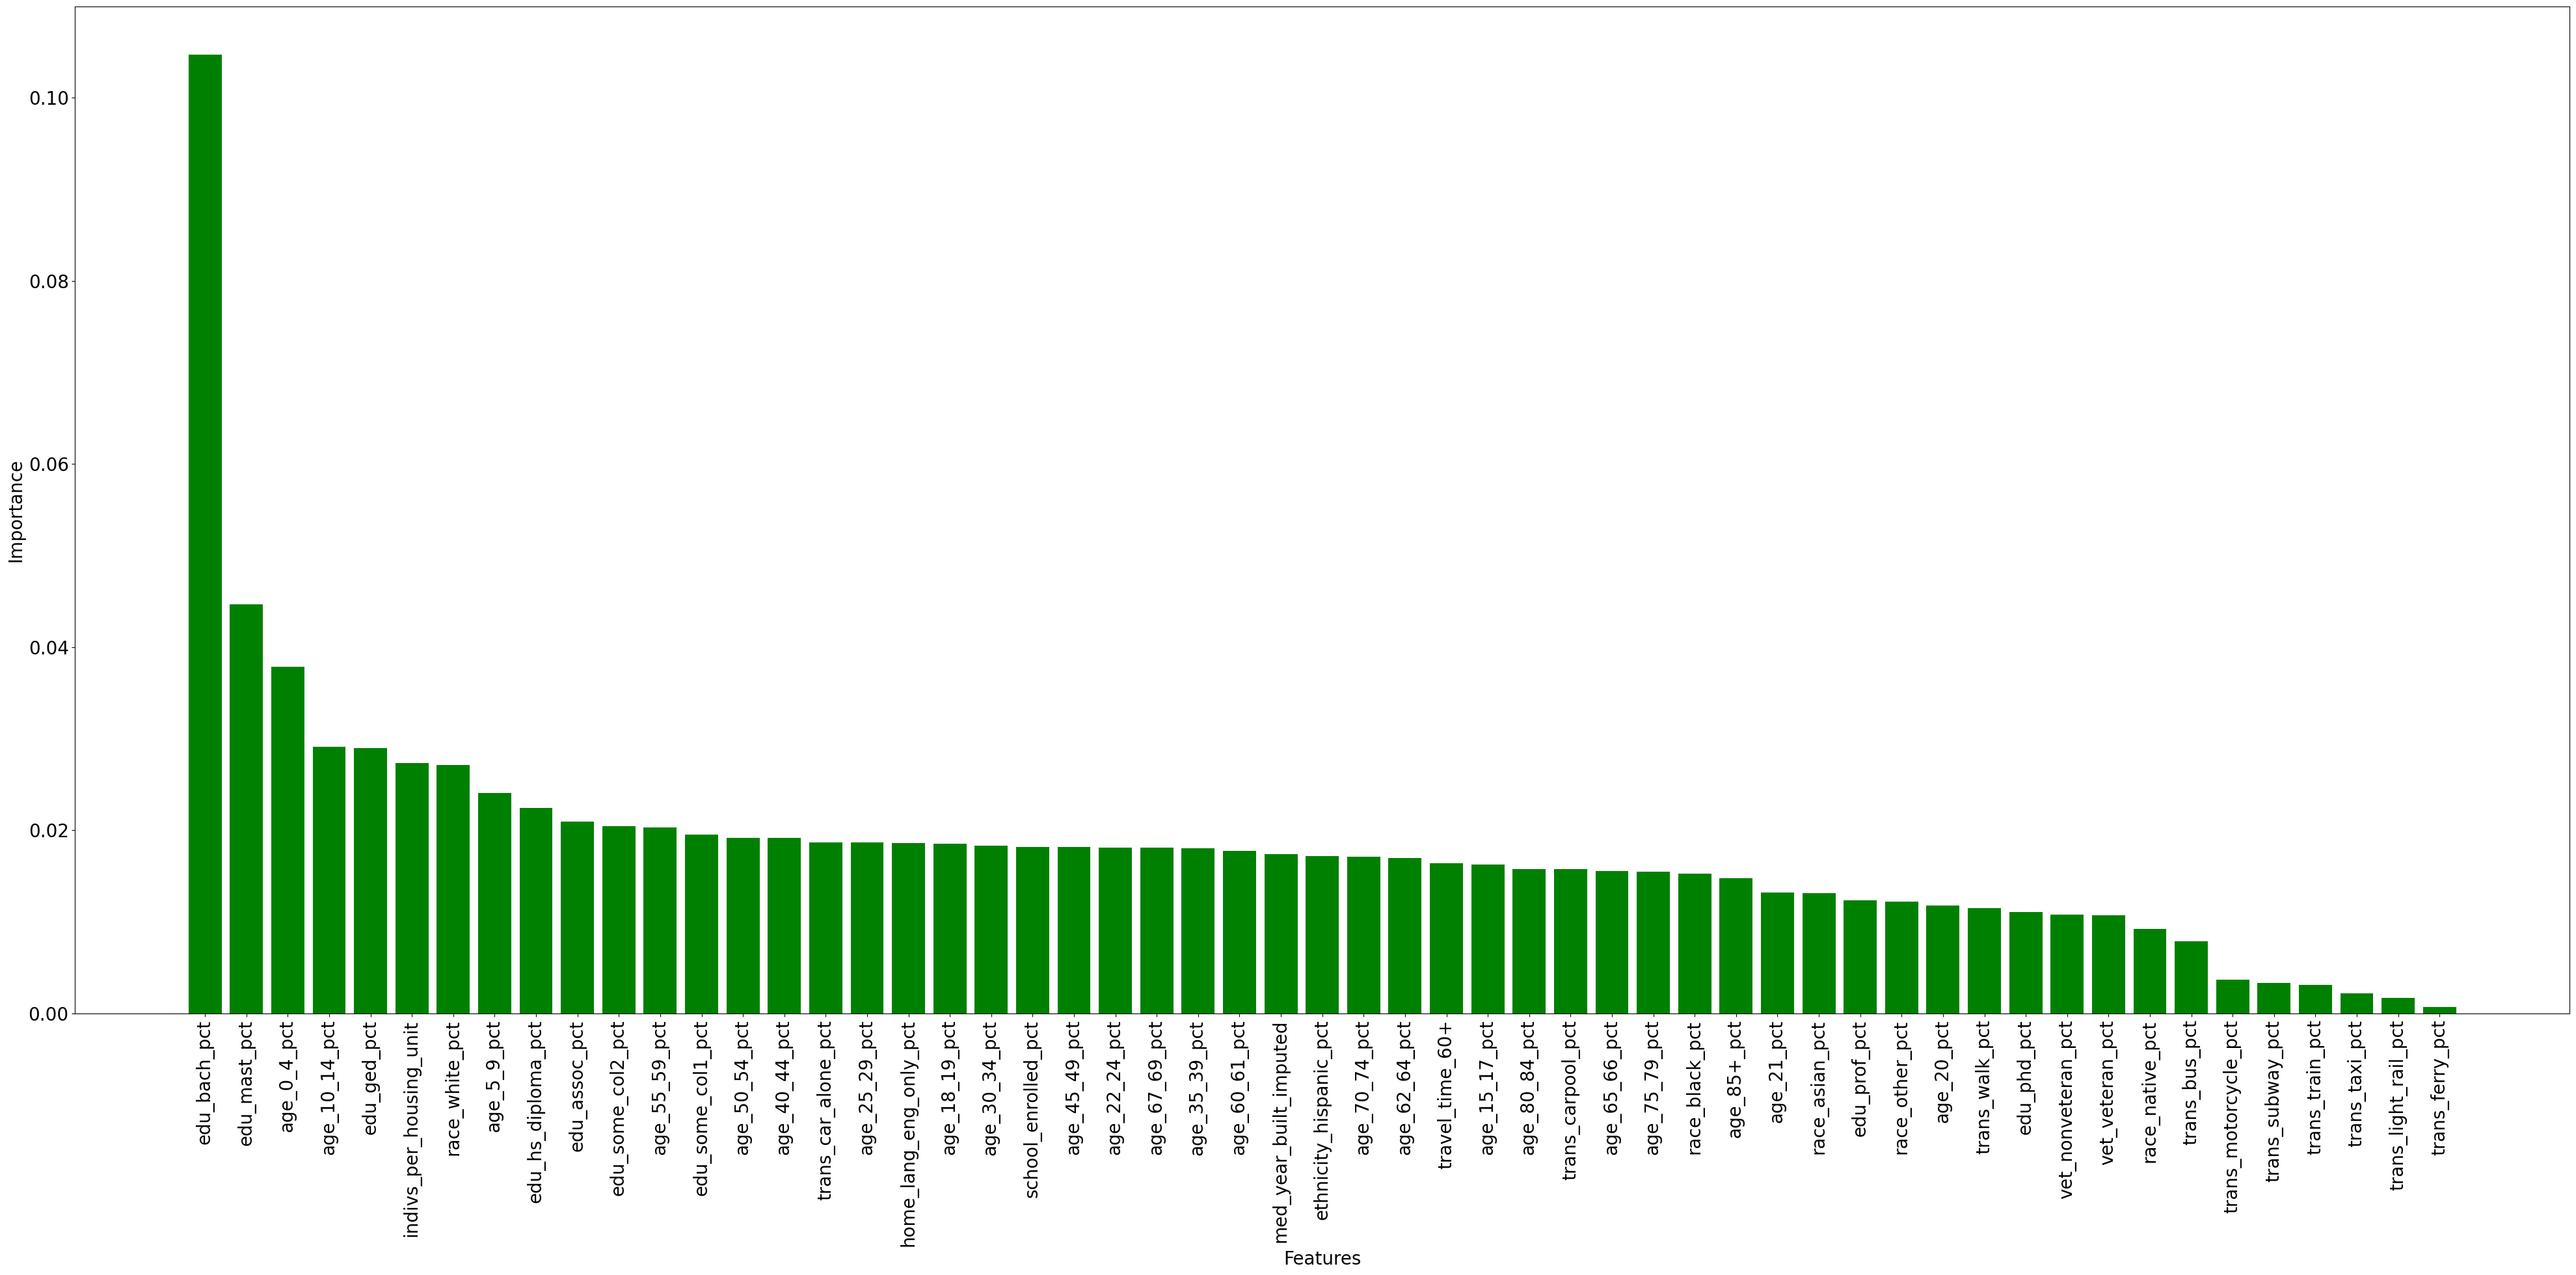

In [39]:
# Create a figure
fig = plt.figure(figsize=(40, 20))

# The bar plot of feature importance
plt.bar(df_fi_dtc['Features'], df_fi_dtc['Importance'], color='green')

# Set x-axis
plt.xlabel('Features')

# Set y-axis
plt.ylabel('Importance')

# Rotate the labels
plt.xticks(rotation=90)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/feature_importance_dtc.pdf')
plt.show()

## GridSearchCV tuning

The bulk of my exploration took place in the context of grid search cross-validation. I took a few promising model candidates, comparing them to each other while searching for optimal parameters in parallel.

### Creating the dictionary of the models


First, I generated a dictionary of 4 candidate models.

My rationale for this particular set was as follows:
- "Basic" decision trees are easily interpretable and intuitively would seem reasonably good at making sense of complex relationships between different factors
- Random forest classifiers, while presenting more complexity relative to a single tree, are also far more robust; the nature of a random forest makes it a useful tool in the face of potential input multicollinearity / complexity, making this a very strong model candidate
- Histogram-Based Gradient Boosting provides an alternative stacking approach to predictions, adding a new angle relative to the first two classifiers; it's also suitable for large datasets (which my dataset certainly is)
- Multi-Layer Perceptron classifiers are excellent at modeling complex non-linear relationships, which could certainly be found within this data given the extremely high dimensionality

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models = {
  'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=random_seed),
  'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
  'hgbc': HistGradientBoostingClassifier(random_state=random_seed),
  'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed)
}

In [41]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### Getting the predefined split cross-validator

This section was lifted from the case studies as a necessary preparatory step for grid search.

In [42]:
# Get the:
# feature matrix and target velctor in the combined training and validation data
# target vector in the combined training and validation data
# PredefinedSplit
# See the implementation in pmlm_utilities.ipynb
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

### Creating the dictionary of the parameter grids


I initialized a dictionary of parameter grids and added each model to it; while more options were used during the grid search tuning process, I've left only the optimal parameters in the interest of time (even if the resulting optimum ended up being a default parameter value that doesn't require specification).

As a general theme, the random forest and multi-layer perceptron models faced the most significant challenges with respect to overfitting, especially under alternate target variable bins.

In [43]:
param_grids = {}

In [44]:
param_grids['dtc'] = [{
  'model__min_samples_split': [10],
  'model__min_samples_leaf': [20],
  'model__max_depth': [4],
  'model__max_features': ['sqrt']
}]

In [45]:
param_grids['rfc'] = [{
  'model__min_samples_split': [20],
  'model__min_samples_leaf': [20],
  'model__n_estimators': [100],
  'model__max_depth': [10],
  'model__max_features': ['log2']
}]

In [46]:
param_grids['hgbc'] = [{
  'model__learning_rate': [1],
  'model__min_samples_leaf': [20],
  'model__max_iter': [100],
  'model__max_depth': [3],
  'model__max_features': [0.5]
}]

In [47]:
param_grids['mlpc'] = [{
  'model__alpha': [10 ** -3],
  'model__learning_rate': ['adaptive'],
  'model__early_stopping': [True],
  'model__hidden_layer_sizes': [(100,)]
}]

### Conducting grid search


With my chosen parameters, the next step was to conduct grid search (largely lifted from case studies). Notably, I ended up using precision as my target (rather than f1 macro); the keras model shown later was facing some issues under this approach.

Precision is the rate of correctly predicted positives over total predicted positives, meaning that it aims to minimize the false positive rate; I think this is still a relatively useful goal with respect to potential real-world applications.

In [48]:
# Conduct grid search (largely lifted from case studies)

from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    print(f"Processing: {acronym}")
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='precision', # Note use of precision here, aligning with model later on
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True,
                      verbose=3) # Added verbose to track progress in longer training runs

    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)

    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score',
                         'std_test_score',
                         'mean_train_score',
                         'std_train_score',
                         'mean_fit_time',
                         'std_fit_time',
                         'mean_score_time',
                         'std_score_time']

    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr + 'result/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

Processing: dtc
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Processing: rfc
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Processing: hgbc
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Processing: mlpc
Fitting 1 folds for each of 1 candidates, totalling 1 fits


,best_score,best_param,best_estimator
0,0.837057,"{'model__max_depth': 10, 'model__max_features'...","((DecisionTreeClassifier(max_depth=10, max_fea..."
1,0.805380,"{'model__max_depth': 4, 'model__max_features':...",(DecisionTreeClassifier(class_weight='balanced...
2,0.776294,"{'model__learning_rate': 1, 'model__max_depth'...",(HistGradientBoostingClassifier(learning_rate=...
3,0.766709,"{'model__alpha': 0.001, 'model__early_stopping...","(MLPClassifier(alpha=0.001, early_stopping=Tru..."


After crafting optimized models as shown above, I attempted to combine them using a voting method to see if the combined precision score would exceed the best individual model. Unfortunately, the result ended up as the reverse, performing worse than any of the individual models!

In [49]:
from sklearn.ensemble import VotingClassifier

models_optimal = {
  'dtc': DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=20, max_depth=4, max_features='sqrt'),
  'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed, min_samples_split=20, min_samples_leaf=20, n_estimators=100, max_depth=15, max_features='log2'),
  'hgbc': HistGradientBoostingClassifier(random_state=random_seed, learning_rate=1, min_samples_leaf=20, max_iter=100, max_depth=3, max_features=0.5),
  'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed, alpha=10 ** -3, learning_rate='adaptive')
}

# Create the voting classifier

voting_clf = VotingClassifier(
    estimators=[('dtc', models_optimal['dtc']), ('rfc', models_optimal['rfc']), ('hgbc', models_optimal['hgbc']), ('mlpc', models_optimal['mlpc'])],
    voting='soft'  # Uses 'soft' instead of 'hard' after testing both
)

# Train the voting classifier and print predictions

voting_clf.fit(X_train, y_train)

y_val_pred = voting_clf.predict(X_val)

from sklearn.metrics import classification_report, precision_score

print(classification_report(y_val, y_val_pred))
print("Precision (macro):", precision_score(y_val, y_val_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.61      0.39      0.48     10981
           1       0.77      0.89      0.83     25611

    accuracy                           0.74     36592
   macro avg       0.69      0.64      0.65     36592
weighted avg       0.73      0.74      0.72     36592

Precision (macro): 0.6935917239667277


## Attempting a sequential network with Keras

My final attempt at exceeding grid search results was a custom neural network model. The grid search multi-layer perceptron model didn't appear to allow for strategies like drop-out, for instance, that I thought I may be able to balance against complexity to ultimately improve performance.

I made multiple attempts at tuning with different activation functions, layer sizes, and dropout rates; however, the optimal set of inputs I found still did not beat the precision score from my grid search. or make huge gains relative to the prior MLP model.

In [50]:
# Build a sequential keras model with a dropout layer
# Note elu activation, chosen after testing various options

model = keras.models.Sequential([keras.layers.Input(shape=(55,)),
                                 keras.layers.Dense(50, activation='elu'),
                                 keras.layers.Dense(50, activation='elu'),
                                 keras.layers.Dropout(rate=0.06),
                                 keras.layers.Dense(1, activation='sigmoid')])

optimizer = keras.optimizers.SGD(
    learning_rate=0.02,
)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['precision'])


In [51]:
# Early stopping and model checkpoint callbacks

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model/model.weights.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [52]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.5609 - precision: 0.7453 - val_loss: 0.5280 - val_precision: 0.7533
Epoch 2/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.5292 - precision: 0.7565 - val_loss: 0.5226 - val_precision: 0.7593
Epoch 3/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.5239 - precision: 0.7603 - val_loss: 0.5201 - val_precision: 0.7615
Epoch 4/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5205 - precision: 0.7629 - val_loss: 0.5185 - val_precision: 0.7638
Epoch 5/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5182 - precision: 0.7649 - val_loss: 0.5173 - val_precision: 0.7651
Epoch 6/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5166 - precision: 0.7658 - val_loss: 0.5163 - val_precision: 0.7669
Epoch 7/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.5149 - precision: 0.7668 - val_loss: 0.5156 - val_precision: 0.7668
Epoch 8/50
4574/4574 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.5134 

# Conclusion

## Takeaways and practical implementation

Ultimately, my best model (a random forest classifier tuned via grid search) had a precision score of ~83%! In other words, roughly 83% of the model's predictions of poverty presence turned out to be true.

Considering the nature of my inputs (which explicitly excluded major employment considerations along with a multitude of factors that the ACS doesn't track), I think this is a fairly strong indicator that the the factors in question do indeed have a strong impact on poverty in the United States.

Given more time and resources, I think that models of this style could prove useful as a platform for guiding public decision-making. A model with very low false positive rates could, for instance, prove to be a valuable tool when planning significant investments (outreach efforts, deployments, etc.) that either address or are strongly intertwined with poverty incidence.

## Next steps

With more time, I think that there are a number of valuable directions in which this modeling approach could be taken:

- **Geography**: I didn't have the knowledge to effectively incorporate geographical factors (coordinates, proximity to cities, etc.) that could help further explain poverty incidence.
- **Other sources**: the American Community Survey, while extensive, is not a fully comprehensive listing of every possible poverty factor. Perhaps moving to larger breakouts, such as state counties, school districts, etc., could allow me to integrate my dataset with other sources containing such data above the Census block level. For instance, rural/urban visits, crime rates, public health characteristics, and others weren't available for my investigation.
- **Model architectures**: My use of model architectures was quite limited (in line with my knowledge), and I imagine that there were missed opportunities to test out other potentially suitable structures.
- **Reframing the problem**: It's possible that my approach isn't the most useful from a policy perspective; for instance, maybe building a massive collection of models -- where each state county is modeled separately based on data over time -- could be used to forecast future poverty incidence distributions effectively and act proactively in ways that a more general nation-wide model cannot allow for.
